In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import struve,yn
from scipy.integrate import quad,nquad
#import numba
from ase.units import Hartree,Bohr
%matplotlib inline

In [13]:
#@numba.jit(nopython=True)
def wave_exciton(x,a):
    return np.sqrt(2/(np.pi*a**2))*np.exp(-x/a)

#@numba.jit(nopython=True)
def wave_trion(x,y,a,b):
    Norm=np.sqrt(1+16*a**2*b**2/(a+b)**4)
    wave=wave_exciton(x,a)*wave_exciton(y,b)
    wave+=wave_exciton(x,b)*wave_exciton(y,a)
    wave/=np.sqrt(2)
    wave/=Norm
    return wave

In [14]:
x_max=100
y_max=100

x_min=0.01
y_min=0.01

In [164]:
r=np.load('MoS2_alone_r.npy')
W_eh=np.load('MoS2_alone_W_eh.npy')

In [165]:
def Keldysh_art(r):
    #if r==0: return 0
    r0=2*np.pi*6.6
    return np.pi/(4*r0)*(struve(0,r/r0)-yn(0,r/r0))

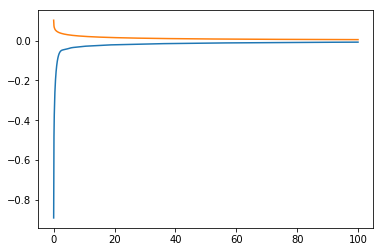

In [166]:
fig, ax = plt.subplots()

ax.plot(r, W_eh)

ax.plot(r, Keldysh_art(r))

plt.show()

In [183]:
def integrand_V1_art(rx,ry,a,b):
    return Hartree*rx*ry*wave_trion(rx,ry,a,b)**2*Keldysh_art(rx)

def V1_art(a,b):
    return (2*np.pi)**2*nquad(integrand_V1_art,[[x_min,x_max],[y_min,y_max]],
                                        args=(a,b),opts={'limit':200})[0]

def integrand_V3_art(rx,ry,a,b):
    return Hartree*rx*ry*wave_trion(rx,ry,a,b)**2*Keldysh_art(ry)

def V3_art(a,b):
    return (2*np.pi)**2*nquad(integrand_V3_art,[[x_min,x_max],[y_min,y_max]],
                                        args=(a,b),opts={'limit':200})[0]

# def integrand_V2_art(rx,ry,a,b):
#     def Keldysh_radial(phi):
#         r_new=np.sqrt(rx**2+ry**2-2*rx*ry*np.cos(phi))
#         return Keldysh_art(r_new)
#     return Hartree*rx*ry*wave_trion(rx,ry,a,b)**2*quad(Keldysh_radial, 0, 2*np.pi, limit=200)[0]

def Keldysh_radial(phi,rx,ry,a,b):
    r_new=np.sqrt(rx**2+ry**2-2*rx*ry*np.cos(phi))
    return Keldysh_art(r_new)
    
def integrand_V2_art(rx,ry,a,b):
    return Hartree*rx*ry*wave_trion(rx,ry,a,b)**2*quad(Keldysh_radial,0, 2*np.pi, args=(rx,ry,a,b), limit=200)[0]

                                                           
def V2_art(a,b):
    return 2*np.pi*nquad(integrand_V2_art,[[x_min,x_max],[y_min,y_max]],
                                       args=(a,b),opts={'limit':200})[0]

#def K1(a,b):
  #  eff_mass=0.277
  #  Norm=1+16*a**2*b**2/(a+b)**4
   # return Hartree*Bohr**2*(1/(2*a**2)+1/(2*b**2)+8*(a**2+b**2)/(a+b)**4)/eff_mass/Norm

def K1(a,b):
    eff_mass=0.277
    Norm=1+16*a**2*b**2/(a+b)**4
    return Hartree*Bohr**2*(-1/(2*a**2)-1/(2*b**2)-16*(a*b)/(a+b)**4)/eff_mass/Norm

In [182]:
x=np.zeros(2)
def Energy_art(x):
    return -K1(x[0],x[1])-V1_art(x[0],x[1])-V3_art(x[0],x[1])+V2_art(x[0],x[1])

In [184]:
from scipy.optimize import minimize

value_min = minimize(Energy_art, [10, 25],bounds=[(5,50),(5,50)],method='L-BFGS-B',options={'disp':1})

value_min

      fun: -0.5431032993956847
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.64783808e-06,  2.23154828e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 5
   status: 0
  success: True
        x: array([10.24245158, 22.28052178])

In [9]:
def Keldysh_art(r):
    #if r==0: return 0
    r0=2*np.pi*6.6
    return np.pi/(4*r0)*(struve(0,r/r0)-yn(0,r/r0))

def K_ex(a):
    return Hartree*Bohr**2/(2*0.277*a**2)

def integrand_V1_ex(r,a):
    return Hartree*r*wave_exciton(r,a)**2*Keldysh_art(r)

def V1_ex(a):
    return 2*np.pi*quad(integrand_V1_ex, x_min, x_max, args=(a,), limit=200)[0]

def gs(a):
    return K_ex(a)-V1_ex(a)


In [10]:
K_ex(10)

0.1375444794305735

In [15]:
V1_ex(10)

0.6571380822871462

In [16]:
from scipy import optimize

value_min = optimize.minimize(gs, [2])

value_min

      fun: -0.5195956525594564
 hess_inv: array([[190.03772219]])
      jac: array([-3.93390656e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([10.02770703])